# **Automated Coverage Check using AI techniques**



## Overview

The goal of this project is to automate the coverage check part in the POC process at IDD. 

Coverage checks are usually done manually because the client naming of financial products is different than our internal naming. 
We want to build a program using NLP and ML techniques that will find the best match, given a defined confident level. <br> What is the IDD product behind the client's own reference name ?



In [12]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

sys.path.append("""C:\\David\\ML\\AICovcheck""")


In [121]:
#import our model
import Aicovcheck

## Creating the knowledge base

In [18]:
#first we get the knowledge base
database_assets_df ,prevPOCs_df, additional_knowledge_df = Aicovcheck.get_data()

Source of knowledge 1: our own  internal naming 

In [19]:
#internal reference 
pd.DataFrame({"IDD_ref":database_assets_df["IDD_ref"]}).sample(10)

,IDD_ref
722,Lower Hudson Valley.IFED
828,BLNG3 Index.BALT
663,Mich Hub DA Peak.IFED
684,North LZ DA Off-Peak.IFED
892,TC8 Index.BALT
145,SREC-MA.IFED
10,CEGH Czech VTP.EEX
203,CBL Global Emissions Offset Futures
787,Tanker Route TD8.BALT
706,Con DA Off-Peak.IFED


Source of knowledge 2: past POCs we manually mapped over the years 

In [20]:
#past POCs we manually mapped, used as knowledge base
prevPOCs_df[["Client_ref", "IDD_ref", "Client"]].sample(10, random_state=42)

,Client_ref,IDD_ref,Client
309,Aluminium options,Aluminium.LME,Bluecrest
622,BTM-BAKKT BITCOIN (USD) MONTHLY FUTURE,Bakkt Bitcoin.IFUS,OCBC
184,USGC HSFO (PLATTS) FUTURE,USGC HSFO.IFED,OCBC
705,SYS-FUEL OIL 380 CST SINGAPORE FUTURE,Fuel Oil 380 CST Singapore.IFEU,OCBC
522,KC HRW WHEAT FUTURES,KC HRW Wheat Future,OCBC
582,CC1-COCOA SPREAD OPTIONS,Cocoa.IFUS,OCBC
464,TD3C FFA - Middle East Gulf to China (Baltic),TD3C.IFEU,Mitsubishi
423,EUA Futures Options (Futures Style Margin),EUA.NDEX,Walleye
355,ICE ECX EUA Emission Futures,EUA.NDEX,Cargill
43,MFT-FUEL OIL CRACK - MARINE FUEL 0.5% FOB SING...,Marine Fuel 0.5% FOB Singapore.IFEU,OCBC


Source of knowledge 3: additional knowledge from Market Data Analyst. 
For example, we provide him the full name for accronyms. 

In [21]:
#additional knowledge provided by Market Data Analyst
additional_knowledge_df[["Client_ref", "IDD_ref", "Client"]].sample(10)

,Client_ref,IDD_ref,Client
6,Renewable Energy Certificate-PJM Class I Prior...,REC-PJM CI PY.IFED,IDD
33,US nat gas,Henry Hub.NYMEX,IDD
8,Solar Renewable Energy Certificate-Pennsylvania,SREC-PA.IFED,IDD
27,Regional Greenhouse Gas Initiative V24,RGGI V24.IFED,IDD
31,Coffee Arabica,Coffee C.IFUS,IDD
14,Renewable Energy Certificate-CT Class I,REC-CT CI.IFED,IDD
15,Renewable Energy Certificate-NJ Class I,REC-NJ CI.IFED,IDD
24,Renewable Energy Certificate-Texas Front Half,REC-TX FH.IFED,IDD
22,Renewable Energy Certificate-NAR Front Half,REC-NAR FH.IFED,IDD
28,API2,Rotterdam Coal.IFEU,IDD


## Preprocessing of the data. 
For this, we worked on several techniques. 

### Cleaning the reference

1. we remove useless words creating noise
2. same for common characters 
3. we create an artificial distance between words that spell similarly but mean opposite concept


```python
words_to_remove = ["fut", "future","futures", "swap", "swp", "crack", "diff", "platts", "bbls", "in bbls",
                "mini", "1st line", "balmo", "spread","option","options","calendar","opt","e-mini".,
                "fixed price","absolute","absolutes",'long','basis','short dated','outright','micro'
                ,"monday","tuesday","wednesday","thursday","friday","monthly","quarterly","quarter","month",
                "week", "weekly", "daily"
                ]

chr_to_remove  = ["-","_", ":", "(", ")",".",";","/","[","]","{","}"]

word_to_replace_dict = {
                   "off peak" : "YYYYY",
                   "offpeak" : "YYYYY",
                    "peak": "XXXXX",
                   "dayahead" : "ZZZZZ",
                   "day ahead" : "ZZZZZ",
                   "da" : "ZZZZZ",
                   "rt" : "AAAAA",
                   "real time": "AAAAA",
                   "realtime": "AAAAA",
                   "meal" :"BBBBB",
                   "h o":"heating oil",
                   "h.o.":"heating oil",
                   "north":"00000",
                   "east":"11111",
                   "west":"22222",
                   "south":"33333"
                   }

```

In [23]:
# let's take few examples:
data_test = prevPOCs_df[["Client_ref"]].sample(10, random_state=42)


data_test["Client_ref_preprocessed"] = data_test.Client_ref.apply(lambda x: Aicovcheck.remove_words_from_string(x.lower()))
data_test.Client_ref_preprocessed = data_test.Client_ref_preprocessed.apply(lambda x: Aicovcheck.remove_chr_from_string(x.lower()))
data_test.Client_ref_preprocessed = data_test.Client_ref_preprocessed.apply(lambda x: Aicovcheck.replace_word_from_string(x.lower()))

data_test.head(10)

,Client_ref,Client_ref_preprocessed
309,Aluminium options,aluminium
622,BTM-BAKKT BITCOIN (USD) MONTHLY FUTURE,btm bakkt bitcoin usd
184,USGC HSFO (PLATTS) FUTURE,usgc hsfo
705,SYS-FUEL OIL 380 CST SINGAPORE FUTURE,sys fuel oil 380 cst singapore
522,KC HRW WHEAT FUTURES,kc hrw wheat
582,CC1-COCOA SPREAD OPTIONS,cc1 cocoa
464,TD3C FFA - Middle East Gulf to China (Baltic),td3c ffa middle 11111 gulf to china baltic
423,EUA Futures Options (Futures Style Margin),eua style margin
355,ICE ECX EUA Emission Futures,ice ecx eua emission
43,MFT-FUEL OIL CRACK - MARINE FUEL 0.5% FOB SING...,mft fuel oil marine fuel 0 5% fob singapore


### Tranforming words into numeric values
Then we tokenize our references to transform them into vectors.
The model will learn the vocabulary contained in all our knowledge base (fit phase) and transform our product names into vectors based on the frequency of appeareance of each words (decomposed in bi and tri-gram).

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))
data_test["Client_ref_tokennized"] = [vectorizer.fit([item]).get_feature_names_out() for item in data_test.Client_ref_preprocessed]

data_test.head()

,Client_ref,Client_ref_preprocessed,Client_ref_tokennized
309,Aluminium options,aluminium,"[al, alu, in, ini, iu, ium, lu, lum, mi, min, ..."
622,BTM-BAKKT BITCOIN (USD) MONTHLY FUTURE,btm bakkt bitcoin usd,"[ b, ba, bi, u, us, ak, akk, ba, bak, bi, ..."
184,USGC HSFO (PLATTS) FUTURE,usgc hsfo,"[ h, hs, c , c h, fo, fo , gc, gc , hs, hsf, ..."
705,SYS-FUEL OIL 380 CST SINGAPORE FUTURE,sys fuel oil 380 cst singapore,"[ 3, 38, c, cs, f, fu, o, oi, s, si, ..."
522,KC HRW WHEAT FUTURES,kc hrw wheat,"[ h, hr, w, wh, at, c , c h, ea, eat, he, h..."


Now, each product reference was transformed into a numeric vector that we can easily compare !

In [26]:
vectorizer, vectorized_ref = Aicovcheck.tokenize_and_vectorize(list(data_test.Client_ref_preprocessed))
print(vectorized_ref.toarray()[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.2154792  0.         0.2534777  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [27]:
#we run our preprocessing on all our training and test datasets.
database_assets_df, prevPOCs_df, additional_knowledge_df, data_test = Aicovcheck.preprocessing(database_assets_df ,prevPOCs_df, additional_knowledge_df ,data_test)

## Find the best match

We use the KNN model, K-nearest neighbour, to compute the distance between each client reference against our knowledge base and find the closest vector/match. 
If there is no match above a pre-defined distance threshold, we are not returning any match. 


In [28]:
data = prevPOCs_df.loc[~pd.isnull(prevPOCs_df.IDD_ref)]["Client_processed_ref"]

df = pd.concat([prevPOCs_df[["Client_ref", "Client_processed_ref", "IDD_ref", "IDD_processed_ref"]],
                database_assets_df[["Client_ref", "Client_processed_ref", "IDD_ref", "IDD_processed_ref"]]])
df = pd.concat([df[["Client_ref", "Client_processed_ref", "IDD_ref", "IDD_processed_ref"]], 
                additional_knowledge_df[["Client_ref", "Client_processed_ref", "IDD_ref", "IDD_processed_ref"]]])

In [29]:
data_train = Aicovcheck.get_datatrain(data, database_assets_df, additional_knowledge_df, 1)

#we train the model 
knn_model,vectorizer = Aicovcheck.trainKNN(data_train)

#predict the best match
knn_treshold = 0.7
result_df = Aicovcheck.predict_ref(df, data_test, data_train, vectorizer, knn_model, threshold_distance=knn_treshold)

result_df[["Client_ref", "IDD_ref"]].head(10)

,Client_ref,IDD_ref
309,Aluminium options,Aluminium.LME
622,BTM-BAKKT BITCOIN (USD) MONTHLY FUTURE,Bitcoin Future
184,USGC HSFO (PLATTS) FUTURE,USGC HSFO.IFED
705,SYS-FUEL OIL 380 CST SINGAPORE FUTURE,Fuel Oil 380 CST Singapore.IFEU
522,KC HRW WHEAT FUTURES,KC HRW Wheat Future
582,CC1-COCOA SPREAD OPTIONS,Cocoa.IFUS
464,TD3C FFA - Middle East Gulf to China (Baltic),TD3C.IFEU
423,EUA Futures Options (Futures Style Margin),EUA.NDEX
355,ICE ECX EUA Emission Futures,EUA.NDEX
43,MFT-FUEL OIL CRACK - MARINE FUEL 0.5% FOB SING...,Marine Fuel 0.5% FOB Singapore.IFEU


## Cross validation and Distance threshold tuning

### Cross validation: 
To ensure our model is robust, we splitted our dataset in 5 independant and randomly distributed folds. 
We will measure the accuracy of our model on each of them.

![ShuffleSplit](shufflesplit_diagram.png)

In [97]:
df_modelselection = pd.read_csv("""C:\\David\\ML\\data (1)\\result_modelselection.csv""")
df_modelselection.threshold= df_modelselection.threshold.apply(lambda x:round(x, 2))

From the graph below, we see that the 5 Folds have similar results whatever the treshold use which provide us confidence in our model robustness.

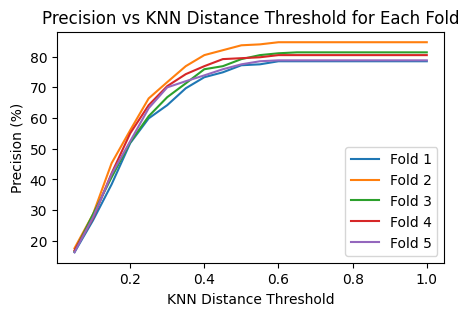

In [98]:
# Setting up the plot
plt.figure(figsize=(5, 3))

# Plotting precision vs threshold for each fold
for fold in df_modelselection['Fold'].unique():
    fold_data = df_modelselection[df_modelselection['Fold'] == fold]
    plt.plot(fold_data['threshold'], fold_data['precision (%)'], label=f'Fold {fold}')

plt.xlabel('KNN Distance Threshold')
plt.ylabel('Precision (%)')
plt.title('Precision vs KNN Distance Threshold for Each Fold')
plt.legend()
plt.show()



### Distance tuning: 
To achieve the best accuracy, we can use a threshold distance of 0.7. 

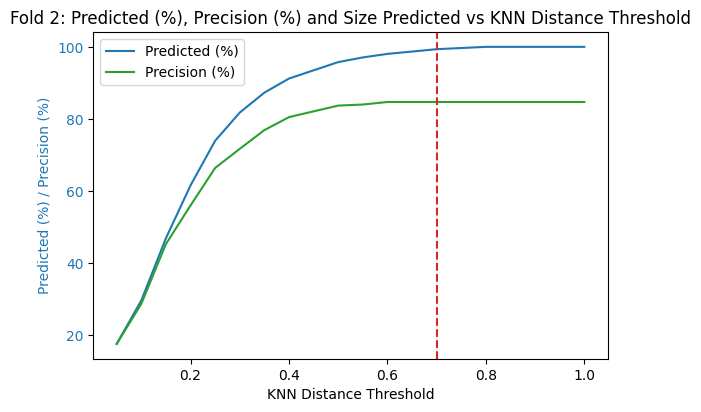

In [99]:
# Filter data for Fold 2
fold_2_data = df_modelselection[df_modelselection['Fold'] == 2]

# Create the plot
fig, ax1 = plt.subplots(figsize=(6, 4))

# y-axis for predicted (%) and precision (%)
ax1.set_xlabel('KNN Distance Threshold')
ax1.set_ylabel('Predicted (%) / Precision (%)', color='tab:blue')
ax1.plot(fold_2_data['threshold'], fold_2_data['predicted (%)'], label='Predicted (%)', color='tab:blue', linestyle='-')
ax1.plot(fold_2_data['threshold'], fold_2_data['precision (%)'], label='Precision (%)', color='tab:green', linestyle='-')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Add a vertical line at threshold = 0.7
ax1.axvline(x=0.7, color='tab:red', linestyle='--', label='Threshold = 0.7')

fig.tight_layout()  # Adjust layout
plt.title('Fold 2: Predicted (%), Precision (%) and Size Predicted vs KNN Distance Threshold')
plt.show()

### Score 

***We achieve an max accuracy of 84.7% <br> For 99% of the references predicted***

In [100]:
df_modelselection[df_modelselection.threshold == 0.7]

,Fold,threshold,predicted (%),sizepredicted,precision (%)
13,1,0.7,99.674,306,78.5
33,2,0.7,99.349,305,84.7
53,3,0.7,100.000,307,81.4
73,4,0.7,98.697,303,80.5
93,5,0.7,99.349,305,78.8


### Importance of each source of knowledge

Here we see the distribution of the source of the match the model found. 

***60% of matches come from past POCs***

we will work on increasing the knowledge from analyst to improve our accuracy even more.

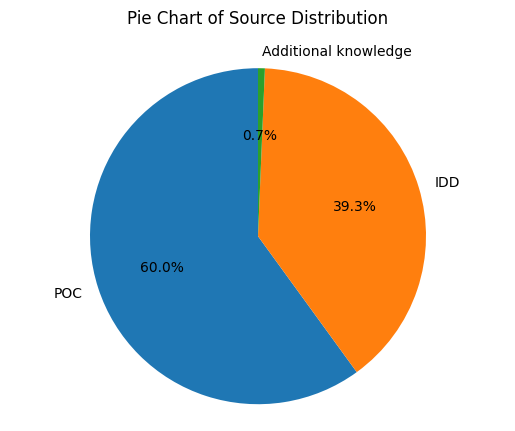

In [111]:

# Create a pie chart for the 'Source' column
source_counts = df_results['Source'].value_counts()
fig, ax = plt.subplots()
ax.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Pie Chart of Source Distribution', pad=20)
plt.show()

## Let's run in a on new POC !!


In [147]:
import Aicovcheck
#del Aicovcheck

In [152]:
#let's import a new POC
data_test = pd.read_excel("""C:\\David\\ML\\data (1)\\FRTB-ICE-Rates-Backfill-Request-Nov2023 - POC COVERAGE.xlsx""")
data_test = pd.DataFrame({"Client_ref": data_test["Asset Description"]})

data_test.head(10)

,Client_ref
0,New Zealand Emissions Units
1,Midland Sweet Crude Trading Month
2,Argus WTI Houston Trade Month
3,WCS Crude at Houston Physical
4,West Texas Sour Trading Month
5,Gasoil 10ppm FOB Singapore
6,Western Canadian Select Physical
7,Gasoline Euro-bob Oxy NWE Barges (Argus)
8,Italian Natural Gas for delivery at Punto di S...
9,French Power Baseload


In [156]:
#preprocessing
database_assets_df, prevPOCs_df, additional_knowledge_df, data_test = Aicovcheck.preprocessing(database_assets_df ,prevPOCs_df, additional_knowledge_df ,data_test)

data_test["Client_processed_ref"] = data_test.Client_ref.apply(lambda x: Aicovcheck.remove_words_from_string(x.lower()))
data_test.Client_processed_ref = data_test.Client_processed_ref.apply(lambda x: Aicovcheck.remove_chr_from_string(x.lower()))
data_test.Client_processed_ref = data_test.Client_processed_ref.apply(lambda x: Aicovcheck.replace_word_from_string(x.lower()))

data_test.head(10)

,Client_ref,Client_processed_ref
0,New Zealand Emissions Units,new zealand emissions units
1,Midland Sweet Crude Trading Month,midland sweet crude trading
2,Argus WTI Houston Trade Month,argus wti houston trade
3,WCS Crude at Houston Physical,wcs crude at houston physical
4,West Texas Sour Trading Month,22222 texas sour trading
5,Gasoil 10ppm FOB Singapore,gasoil 10ppm fob singapore
6,Western Canadian Select Physical,western canadian select physical
7,Gasoline Euro-bob Oxy NWE Barges (Argus),gasoline euro bob oxy nwe barges argus
8,Italian Natural Gas for delivery at Punto di S...,italian natural gas for delivery at punto di s...
9,French Power Baseload,french power baseload


In [157]:
#train the model
data = prevPOCs_df.loc[~pd.isnull(prevPOCs_df.IDD_ref)]["Client_processed_ref"]

data_train = Aicovcheck.get_datatrain(data, database_assets_df, additional_knowledge_df, 1)

In [162]:
#find best match
knn_model,vectorizer = Aicovcheck.trainKNN(data_train)

knn_treshold = 0.7
result_df = Aicovcheck.predict_ref(df, data_test, data_train, vectorizer, knn_model, threshold_distance=knn_treshold)

result_df.sample(20)

,Client_ref,Client_processed_ref,matched_ref,IDD_ref
10,Dutch Natural Gas for delivery at Title Transf...,dutch natural gas for delivery at title transf...,dutch ttf natural gas,TTF.NDEX
32,FERC Index - Houston Ship Channel VWAP,ferc index houston ship channel vwap,wti houston ifed,WTI Houston.IFED
4,West Texas Sour Trading Month,22222 texas sour trading,ep 22222 texas ifed,EP West Texas.IFED
13,"Physical Butane Mont Belvieu Non-TET, United S...","physical butane mont belvieu non tet, united s...",normal butane opis mt belvieu non tet ifed,Normal Butane OPIS Mt. Belvieu Non-TET.IFED
36,Iroquois Pipeline: Waddington NY,iroquois pipeline waddington ny,iroquois into ifed,Iroquois (Into).IFED
2,Argus WTI Houston Trade Month,argus wti houston trade,argus wti houston ifed,Argus WTI Houston.IFED
28,Empress Alberta,empress alberta,None,None
25,Trans Cananda Pipeline: Transgas South Saskatc...,trans cananda pipeline transgas 33333 saskatc...,transco zone 5 33333 ifed,Transco Zone 5 South.IFED
3,WCS Crude at Houston Physical,wcs crude at houston physical,argus wcs houston ifed,Argus WCS (Houston).IFED
12,Paraxylene CMAI North America Contract-Market ...,paraxylene cmai 00000 america contract market ...,paraxylene zce,Paraxylene.ZCE


### Next steps 

1. Increase our training datasets 
2. Increase the knowledge base from Market Data Analyst
3. Develop a UE for the POC team to use in one-clic  
4. try using on open source LLM model 